# Battery Analysis

This jupyter file contains simple analysis of the Nasa dataset, which partly follows/converts the `R` code that was given included with the dataset

In [262]:
# Import important libraries
from scipy import io
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

## Loading the `.mat` data with python

In [263]:
BATTERY = 'RW9' # other batteries include RW10, RW11, RW12
battery_path = f'battery datasets/1.Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab/{BATTERY}.mat'
mat = io.loadmat(battery_path, simplify_cells=True)

## The structure of the dataset

This is how the data may look like, there're 3 different types of reference profiles: `C` (charge), `D` (discharge), and `R` (rest).

There's also 15 different `comment`s, with describe how these 3 profiles were performed. 

In [264]:
df = pd.DataFrame(mat['data']['step'])
df.drop_duplicates(subset=['comment']).sort_values('type') # Filter part of the data to get a better grip of how it's structured

,comment,type,time,relativeTime,voltage,current,temperature,date
0,reference charge,C,"[5.04, 15.04, 25.04, 35.04, 45.04, 55.04, 65.0...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[3.838, 3.865, 3.878, 3.888, 3.895, 3.9, 3.905...","[-2.007, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -...","[24.3853, 24.3853, 24.29163, 24.2448, 24.26041...",06-Jan-2014 13:36:43
37,charge (random walk),C,"[81839.84, 81840.84, 81841.84000000001, 81842....","[0.04, 1.04, 2.04, 3.04, 4.04, 5.04, 6.04, 7.0...","[3.935, 3.943, 3.949, 3.954, 3.959, 3.963, 3.9...","[-1.502, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -...","[30.25273, 30.25273, 30.26819, 30.26819, 30.25...",07-Jan-2014 12:20:46
3035,pulsed charge (charge),C,"[456986.28, 456987.27999999997, 456988.2799999...","[0.04, 1.04, 2.04, 3.04, 4.04, 5.04, 6.04, 7.0...","[3.346, 3.376, 3.382, 3.388, 3.393, 3.398, 3.4...","[-1.002, -1.0, -1.0, -1.0, -1.0, -1.0, -0.999,...","[22.32458, 22.32458, 22.32458, 22.32458, 22.32...",11-Jan-2014 20:45:18
1,reference discharge,D,"[10509.699999999999, 10519.7, 10529.7, 10539.6...","[0.04, 10.04, 20.04, 30.04, 40.04, 50.04, 60.0...","[4.113, 4.099, 4.091, 4.085, 4.079, 4.075, 4.0...","[1.004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...","[22.10602, 22.05919, 22.04357, 22.01235, 21.98...",06-Jan-2014 16:31:49
5,pulsed load (discharge),D,"[48058.11, 48059.11, 48060.11, 48061.11, 48062...","[0.04, 1.04, 2.04, 3.04, 4.04, 5.04, 6.04, 7.0...","[4.112, 4.108, 4.107, 4.105, 4.104, 4.103, 4.1...","[1.005, 0.999, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0,...","[23.13638, 23.13638, 23.13638, 23.13638, 23.13...",07-Jan-2014 02:57:41
31,discharge (random walk),D,"[80938.33, 80939.33, 80940.33, 80941.33, 80942...","[0.04, 1.04, 2.04, 3.04, 4.04, 5.04, 6.04, 7.0...","[4.068, 4.063, 4.061, 4.058, 4.057, 4.055, 4.0...","[1.503, 1.5, 1.499, 1.5, 1.5, 1.5, 1.5, 1.499,...","[22.7617, 22.7617, 22.7617, 22.7617, 22.77732,...",07-Jan-2014 12:05:44
37626,low current discharge at 0.04A,D,"[4955484.58, 4955494.58, 4955504.58, 4955514.5...","[0.15, 10.15, 20.15, 30.15, 40.15, 50.15, 60.1...","[4.196, 4.191, 4.19, 4.19, 4.189, 4.189, 4.189...","[0.001, 0.04, 0.04, 0.04, 0.04, 0.04, 0.039, 0...","[28.67846, 28.67846, 28.67846, 28.67846, 28.67...",04-Mar-2014 17:05:15
4,pulsed load (rest),R,"[46858.079999999994, 46859.079999999994, 46860...","[0.01, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.0...","[4.199, 4.199, 4.199, 4.199, 4.199, 4.199, 4.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[22.99587, 22.98026, 22.98026, 22.98026, 22.98...",07-Jan-2014 02:37:40
30,rest (random walk),R,"[80938.11, 80938.29000000001]","[0.01, 0.19]","[4.199, 4.199]","[0, 0]","[22.7617, 22.7617]",07-Jan-2014 12:05:42
3034,pulsed charge (rest),R,"[455786.25, 455787.25, 455788.25, 455789.25, 4...","[0.01, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.0...","[3.201, 3.202, 3.202, 3.202, 3.202, 3.202, 3.2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[23.12077, 23.12077, 23.13638, 23.13638, 23.12...",11-Jan-2014 20:25:18


## Example Plots of Low Current Discharge Cycles

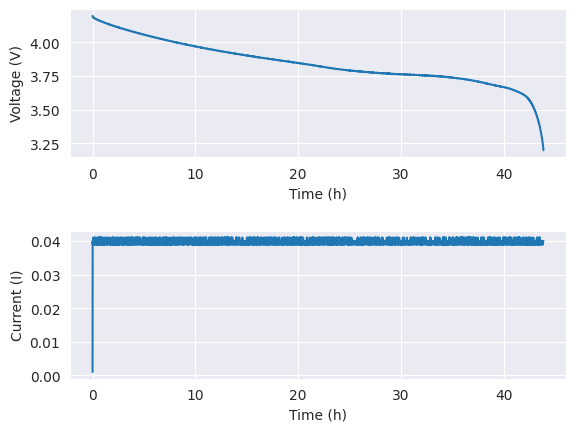

In [265]:
df = pd.DataFrame(mat['data']['step'])
df = df.query('comment == "low current discharge at 0.04A"')

time_hour = df.iloc[0]['relativeTime'] / 3600
voltage = df.iloc[0]['voltage']
current = df.iloc[0]['current']

sns.set_style("darkgrid")
plt.subplot(2, 1, 1)
sns.lineplot(x=time_hour, y=voltage)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')

plt.subplot(2, 1, 2)
sns.lineplot(x=time_hour, y=current)
plt.xlabel('Time (h)')
plt.ylabel('Current (I)')

plt.subplots_adjust(hspace=0.5)
plt.show()

## The **reference discharge profile**

Is is a cycle consisting of a cycle of fully discharging the the battery when the voltage is the maxiumum.

This cycle will act as our ground truth, eg. used for computing the **capacity** and thus **SoH**. 

Below is a plot of showing how the voltage charging becomes slower for each cycle

> Lightest = first cycle
> 
> Darkest = last cycle

/tmp/ipykernel_13556/3192007443.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sm)


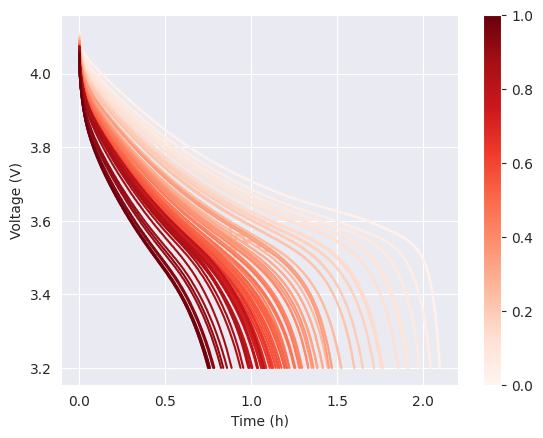

In [266]:
refDissSteps = pd.DataFrame(mat['data']['step'])
refDissSteps = refDissSteps.query('comment == "reference discharge"')
refDissSteps = refDissSteps[['relativeTime', 'voltage']]

sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Reds", n_colors=len(refDissSteps)))
cmap = sns.color_palette("Reds", n_colors=len(refDissSteps), as_cmap=True)

for index, row in refDissSteps.iterrows():
    time_hour = row['relativeTime'] / 3600
    voltage = row['voltage']
    sns.lineplot(x=time_hour, y=voltage, linewidth=1.5)


sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.show()
sns.reset_defaults()


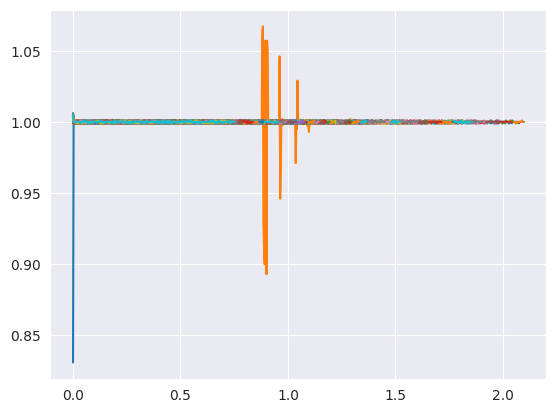

In [267]:
refDissSteps = pd.DataFrame(mat['data']['step'])
refDissSteps = refDissSteps.query('comment == "reference discharge"')
refDissSteps = refDissSteps[['relativeTime', 'current']]
sns.set_style('darkgrid')
for index, row in refDissSteps.iterrows():
    time_hour = row['relativeTime'] / 3600
    voltage = row['current']
    sns.lineplot(x=time_hour, y=voltage, linewidth=1.5)
    
plt.show()

## Compute the Capacity and SoH with the Reference Discharge

To compute the capacity, one can simple integrate the current (I) over the relative time interval (s) during the reference discharge cycle:
$$
Capacity = \int_{t_1}^{t_2} f(t)dt \ 
t_1 = \text{time when the battery is fully charged} \ 
t_2 = \text{time when the battery is fully discharged}
$$

This can be achived using the code below using the `np.trapz()` function to approximate the integral. Futhermore, the SoH is simply computed by:
$$
SoH (Capacity) = \frac{Capacity}{Capacity_{inital}}
$$

In [268]:
format_string = "%d-%b-%Y %H:%M:%S"

refDisSteps = pd.DataFrame(mat['data']['step'])
refDisSteps = refDisSteps.query('comment == "reference discharge"')
refDisSteps['date'] = refDisSteps['date'].apply(lambda x: datetime.strptime(x, format_string)) # Change 'date' to the right format 
refDisSteps['capacity (Ah)'] = [np.trapz(i, t) / 3600 for i, t in zip(refDisSteps['current'], refDisSteps['relativeTime'])] # Performing the integral
refDisSteps['SoH (capacity)'] = refDisSteps['capacity (Ah)'] /  refDisSteps['capacity (Ah)'].iloc[0] # Compute the SoH

### Computing SoH using the resistance

Another definition of SoH is using the resistance (R) where the formula for it is simply:
$$
R = \frac{V}{I}
$$
Thus it's very easy to compute, the code below does it. Consequently the SoH (resistance) can be computed with:
$$
SoH (resistance) = \frac{R}{R_{initial}}
$$

In [269]:
# Computes the mean voltage and current for each cycle
mean_voltage = refDisSteps['voltage'].apply(lambda x: np.mean(x)) 
mean_current = refDisSteps['current'].apply(lambda x: np.mean(x))
# Thus the mean resitance for each cycle can by computed
refDisSteps['mean resistance'] = mean_voltage / mean_current
# Computing SoH (resistance)
refDisSteps['SoH (resistance)'] = refDisSteps['mean resistance'] / refDisSteps['mean resistance'].iloc[0]

## Plotting capacity, resistance and SoH for both methods

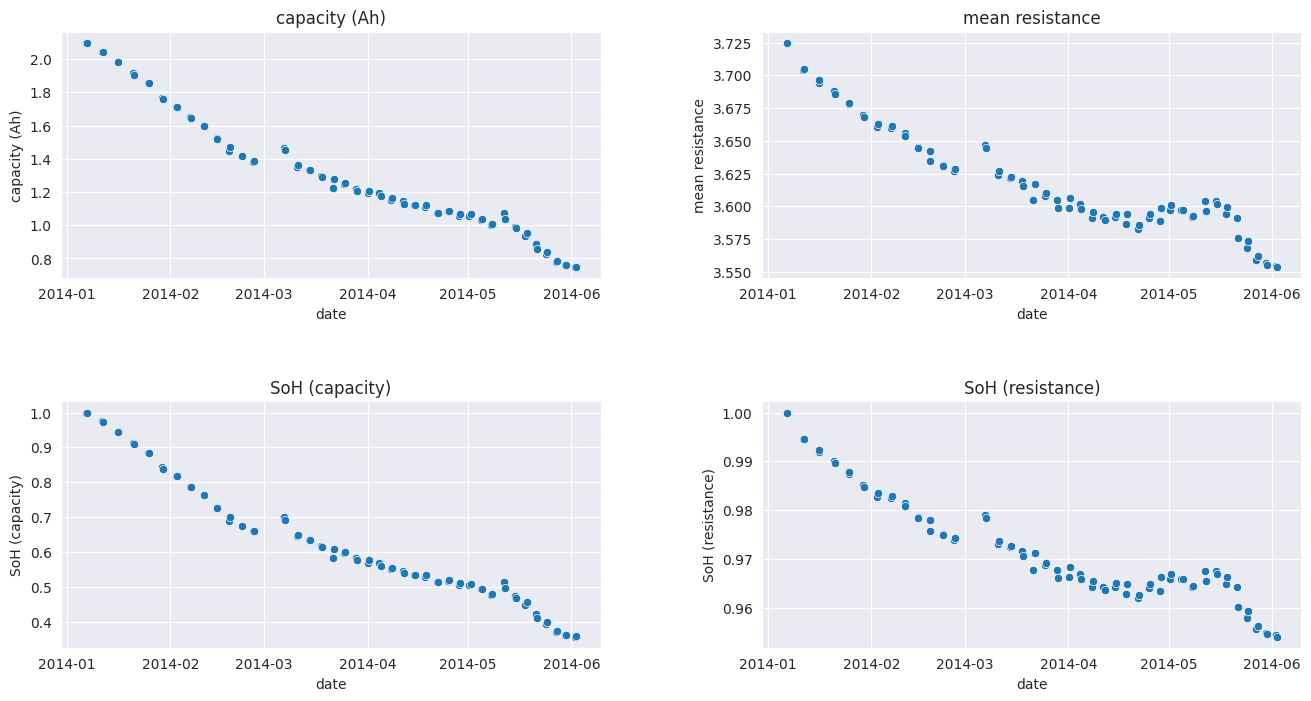

In [270]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

sns.set_style('darkgrid')
axes[0,0].set_title('capacity (Ah)')
axes[0,1].set_title('mean resistance')

sns.scatterplot(data=refDisSteps, x='date', y='capacity (Ah)', ax=axes[0,0])
sns.scatterplot(data=refDisSteps, x='date', y='mean resistance', ax=axes[0,1])


axes[1,0].set_title('SoH (capacity)')
axes[1,1].set_title('SoH (resistance)')
sns.scatterplot(data=refDisSteps, x='date', y='SoH (capacity)', ax=axes[1,0])
sns.scatterplot(data=refDisSteps, x='date', y='SoH (resistance)', ax=axes[1,1])

plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()
